In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

DATA_FOLDER = 'dataset/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"
WIKIDATA_PATH = DATA_FOLDER + "wikidata/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
FEMALES = "data/listwomen.txt"

articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"], skiprows = 17)
females = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

In [238]:
# female_links =
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))
people = categories[categories["category_people"] == True]

people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns=["category_people", "category", 0, 1])
people = people.rename(columns={2:"category", "article": "name"})
# drop duplicates in articles
people = people.drop_duplicates(subset=['name'])

people["gender"] =  people['name'].isin(females["name"])
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()
# inner join - drop all people that have no in_link 
people = people.merge(count_links_src, how="left",  left_on="name", right_index=True)
people = people.merge(count_links_target,how="inner", left_on="name", right_index=True)
people = people.rename(columns={"link_source":"nr_link_out", "link_target": "nr_link_in"})
# people[people["name"].duplicated() == True]




# people

In [239]:
def process_path(path):
    # assumption: going back, increases the path length by 1
    p = path.split(";")
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length

# expand the finished paths 
path_overview = pd.DataFrame()
path_overview["source"], path_overview["target"], path_overview["human_length"] =  zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_overview["finished"] = True

# expand the dataset by unfinished paths
path_uf = pd.DataFrame()
path_uf["source"], path_uf["failure"], path_uf["human_length"] =  zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_uf["finished"] = False
path_uf['target'] = paths_unfinished["target"]

path_overview = pd.concat([path_overview,path_uf])



In [240]:
# save dataframe to file
path_overview.to_csv("./data/all_paths_overview.csv")


In [241]:
path_overview

,source,target,human_length,finished,failure
0,14th_century,African_slave_trade,9,True,NaN
1,14th_century,African_slave_trade,5,True,NaN
2,14th_century,African_slave_trade,8,True,NaN
3,14th_century,Greece,4,True,NaN
4,14th_century,John_F._Kennedy,7,True,NaN
...,...,...,...,...,...
24870,Franz_Kafka,Cholera,8,False,Ghana
24871,Modern_history,Hollandic,1,False,Modern_history
24872,Computer_programming,The_Beatles,5,False,<
24873,Jamaica,Alan_Turing,4,False,Battle_of_Midway


In [242]:
people_target_paths = path_overview.merge(people[['name', 'category', 'gender']], how= "inner", left_on="target", right_on="name")
people_target_paths
len(people_target_paths[people_target_paths['gender'] == True])

689

In [243]:
print("Number of paths with a woman as a target",len(people_target_paths[people_target_paths['gender'] == True]) )
print("Number of paths with a man as a target",len(people_target_paths[people_target_paths['gender'] == False]) )
print("Number of finished paths with a woman as a target",
        len(people_target_paths[(people_target_paths['gender'] == True) & (people_target_paths['finished'] == True)]))
print("Number of finished paths with a man as a target",
        len(people_target_paths[(people_target_paths['gender'] == False) & (people_target_paths['finished'] == True)]))
print("Number of unfinished paths with a woman as a target",
        len(people_target_paths[(people_target_paths['gender'] == True) & (people_target_paths['finished'] == False)]))
print("Number of unfinished paths with a man as a target",
        len(people_target_paths[(people_target_paths['gender'] == False) & (people_target_paths['finished'] == False)]))

Number of paths with a woman as a target 689
Number of paths with a man as a target 7940
Number of finished paths with a woman as a target 347
Number of finished paths with a man as a target 5566
Number of unfinished paths with a woman as a target 342
Number of unfinished paths with a man as a target 2374


In [244]:
tot_target = people_target_paths.target.value_counts().rename("tot_target_count")
unf_target = people_target_paths[people_target_paths['finished'] == False].target.value_counts().rename("unf_target_count")
fin_target = people_target_paths[people_target_paths['finished'] == True].target.value_counts().rename("fin_target_count")
people = people.merge(tot_target, how="left",  left_on="name", right_index=True)
people = people.merge(unf_target, how="left",  left_on="name", right_index=True)
people = people.merge(fin_target, how="left",  left_on="name", right_index=True)




In [245]:
people.columns
# success rate of the finished paths, when this article was the target
people['succ_rate'] = people['fin_target_count']/people['tot_target_count']


In [246]:
min(people['succ_rate'])

0.013574660633484163

In [247]:
people.to_csv("./data/people_overview.csv")

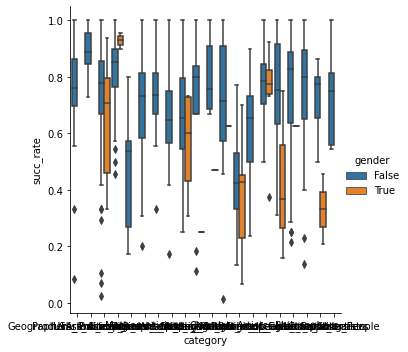

In [248]:
sns.catplot(data=people, x="category", y="succ_rate",hue = "gender", kind="box")